# Basic Hands-on 2: Convolutional neural networks for image classification with CIFAR‑10 

In this session, we dive deeper into the world of deep learning by focusing on Convolutional Neural Networks (CNNs) and their application to image classification. Building upon our introductory MNIST workshop, we now explore more advanced architectures and techniques using the CIFAR‑10 dataset—a widely recognized benchmark in computer vision. CIFAR‑10 consists of 60,000 color images across 10 different classes (such as planes, cars, and animals) and provides a great platform to experiment with CNN design and optimization strategies.

### What we will learn:  
1. **Data Loading and Preprocessing:**  
  Learn how to download, transform, and load the CIFAR‑10 dataset using PyTorch’s torchvision utilities.  
2. **Building a CNN:**  
  Understand how to construct a CNN from scratch using PyTorch’s `nn.Module`. We will cover the role of convolutional layers, activation functions (ReLU), pooling layers, and fully connected layers.  
3. **Training the Model:**  
  Implement a training loop with loss computation (using Cross-Entropy Loss) and optimization (with the Adam optimizer) to update model parameters.  
4. **Model Evaluation:**  
  Evaluate the model’s performance on a test set and calculate its accuracy.  
5. **Making Predictions and Visualization:**  
  Visualize model predictions by displaying a few test images alongside their ground truth labels and model-predicted labels.  
6. **Exploring Improvement Techniques:**  
  Discuss and experiment with various techniques to improve CNN performance, including dropout, batch normalization, and different architectural choices.


###  0. Importing Necessary Libraries

In this step, we import the essential libraries and modules required to build and train the model, as well as visualize results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

###  0. Importing Necessary Libraries: Step-by-Step Explanation

1. `import torch`:  
   This imports the core PyTorch library, which provides the fundamental tools for building and training neural networks.

2. `import torch.nn as nn`:  
   This imports the `torch.nn` module, which contains classes and functions for building neural networks. `nn` stands for neural networks, and it helps define the layers, loss functions, and other essential components needed for model building.

3. `import torch.optim as optim`:  
   This imports the `torch.optim` module, which contains optimization algorithms (such as SGD, Adam, etc.). These optimizers are used to minimize the loss function and update the model parameters during training.

4. `import torchvision`:  
   This imports the `torchvision` library, which provides access to popular datasets (like CIFAR-10, ImageNet), pretrained models, and common image transformations. `torchvision` is very helpful when working with image data.

5. `import torchvision.transforms as transforms`:  
   This imports the `transforms` module from `torchvision`, which provides a variety of image transformation functions. These transformations are applied to the images to prepare them for training or testing, such as resizing, cropping, converting to tensors, and normalizing pixel values.

6. `import matplotlib.pyplot as plt`:  
   This imports `matplotlib.pyplot`, a popular plotting library in Python. It is used to create visualizations, such as plotting images, training curves, or loss graphs. It's an essential tool for understanding and presenting model performance.

7. `import numpy as np`:  
   This imports the `numpy` library, which is used for numerical computations. It provides powerful tools for working with arrays and matrices, and it's often used for data manipulation or preparation tasks when working with machine learning models.


#### **Setting Up the Device (GPU or CPU)**

```python
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
```

This code selects the best available device for running the model. If a GPU (Graphics Processing Unit) with CUDA support is available, it is used for faster computations. If running on a Mac with an Apple Silicon chip (M1/M2), Metal Performance Shaders (MPS) acceleration is used instead. If neither is available, the model will run on the CPU (Central Processing Unit). Using hardware acceleration (GPU or MPS) significantly speeds up training and inference, particularly for large models or datasets.

### 1. Loading and Transforming the Dataset

The CIFAR-10 dataset consists of 60,000 32×32 color images divided into 10 classes (such as planes, cars, birds, cats, etc.). The training set contains 50,000 images, while the test set includes 10,000 images. In this step, we load the training and test sets separately using torchvision and apply necessary transformations.

In [2]:
# 1. Load and Transform Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 1. Loading and Transforming the Dataset: Step-by-Step Explanation

#### **Transformation**

```python
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])
```

- **`transforms.Compose([...])`**: This allows you to combine multiple transformations into a single pipeline. The transformations will be applied sequentially to each image in the dataset.
  
- **`transforms.ToTensor()`**: This converts the image from a PIL image (or a NumPy array) to a PyTorch tensor. Specifically, it performs the following operations:
  - **Conversion to PyTorch tensor:** CIFAR-10 images are 32×32 pixels, so each image is a matrix with the shape (32, 32, 3), where 32 is the width and height, and 3 is the number of channels (red, green, blue). After transformation the image shape becomes (3, 32, 32) (channels, height, width)
  - **Normalization of pixel values:** It converts each pixel value, which initially ranges from 0 to 255, into a floating-point value between 0 and 1. For instance, a pixel with value 255 (fully white) would be converted to `1.0`, while a pixel with value 0 (fully black) would be `0.0`.

- **`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`**: After converting the image to a tensor, this step normalizes the pixel values. It adjusts the range of the pixel values to a new scale using a mean and standard deviation for each channel:
  - **Mean `(0.5, 0.5, 0.5)`**: This means that the average value for each of the three color channels (Red, Green, Blue) will be set to 0.5.
  - **Standard Deviation `(0.5, 0.5, 0.5)`**: This scales the pixel values so that they have a standard deviation of 0.5 in each channel.
  
  The **normalization** formula for each channel is:
  
$$
  \text{normalized pixel} = \frac{\text{pixel value} - \text{mean}}{\text{std}}
$$
  
  The purpose of this normalization is to shift and scale the pixel values into the range \([-1, 1]\), which helps with model convergence during training by providing input values with similar distributions.


#### **Understanding the Dataset Format**

Each image in the CIFAR-10 dataset is 32×32 pixels and has 3 color channels (Red, Green, Blue). So, in terms of numbers:

- **Size of Each Image**:  
  An image is represented as a tensor of shape `(3, 32, 32)`. This means:
  - The first dimension (size `3`) corresponds to the three color channels (Red, Green, Blue).
  - The second and third dimensions (both size `32`) represent the height and width of the image in pixels.
  
  For example, the pixel values for a 32×32 image might look like this:
  - **A Single Pixel**: A pixel's value in each channel could be a floating point number, say `[0.5, 0.3, 0.1]` for Red, Green, and Blue channels, respectively. This means the pixel would have:
    - Red value: `0.5`
    - Green value: `0.3`
    - Blue value: `0.1`

- **Pixel Value Range After Normalization**:  
  After applying `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`, pixel values are scaled to the range `[-1, 1]`. For instance:
  - A Red pixel value of `0.5` would become `0.0` after normalization (since $\frac{0.5 - 0.5}{0.5} = 0.0$).
  - A Green pixel value of `0.3` would become `-0.4` after normalization (since $\frac{0.3 - 0.5}{0.5} = -0.4$).
  - A Blue pixel value of `0.1` would become `-0.8` after normalization (since $\frac{0.1 - 0.5}{0.5} = -0.8$).


#### **Loading the CIFAR-10 Dataset**

```python
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
```

- **`root='./data'`**: The `root` argument specifies the directory where the dataset should be downloaded or loaded from. In this case, it will be saved to the `./data` directory within your current working directory.
  
- **`train=True` and `train=False`**:
  - **`train=True`** means we are loading the training dataset (50,000 images). 
  - **`train=False`** means we are loading the test dataset (10,000 images). This allows you to evaluate the performance of your model on unseen data after training.

- **`download=True`**: This instructs the program to download the CIFAR-10 dataset if it is not already available at the specified location (i.e., in the `root` directory). If the dataset is already present, it won't be downloaded again.

- **`transform=transform`**: This applies the transformations (such as converting to a tensor and normalizing) to the images as they are loaded from the dataset.


#### **Using DataLoader**

- **DataLoader**:  
  The `DataLoader` is a PyTorch utility that batches and loads the dataset. It also provides functionality for shuffling the data during training, ensuring that the model sees the data in a random order during each epoch, which helps prevent overfitting and improves generalization.
  
  - **`batch_size=64`**: This defines how many images will be loaded in a single batch. Here, the batch size is set to 64, so 64 images will be loaded at a time during training.
  - **`shuffle=True` (for training data)**: This ensures that the training data is shuffled before being loaded into the model. This randomness is important to avoid the model memorizing the order of the data.
  - **`shuffle=False` (for test data)**: For the test set, shuffling is typically not necessary, as we simply evaluate the model on the entire dataset in a consistent order.


#### **Classes**

```python
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
```

- The `classes` variable defines the 10 classes in the CIFAR-10 dataset:
  - **`'plane'`, `'car'`, `'bird'`, `'cat'`, `'deer'`, `'dog'`, `'frog'`, `'horse'`, `'ship'`, `'truck'`**.

Each image is labeled with one of these 10 classes.

In [3]:
images, labels  = next(iter(testloader))
print(f"images.shape = {images.shape}")
print(f"labels.shape = {labels.shape}")

images.shape = torch.Size([64, 3, 32, 32])
labels.shape = torch.Size([64])


### 2. Defining the CNN Model

In this section, we build a simple Convolutional Neural Network (CNN) to classify CIFAR‑10 images. The network is composed of convolutional layers, activation functions, pooling layers, and fully connected layers.

- **Convolutional Layers:**  
  - The first convolutional layer has 32 filters with a kernel size of 3×3 and padding of 1. This preserves the spatial dimensions of the input while extracting low-level features.
  - The second convolutional layer increases the number of filters to 64, also using a 3×3 kernel with padding of 1, enabling the extraction of more complex features.

- **Activation and Pooling:**  
  - After each convolution, we apply the ReLU activation function to introduce non-linearity.
  - MaxPooling layers (with a kernel size of 2×2) reduce the spatial dimensions by half, progressively downsampling the feature maps.

- **Fully Connected Layers:**  
  - The output from the convolutional and pooling layers is flattened into a vector.
  - A fully connected layer with 128 neurons is applied, followed by a dropout layer (with a dropout rate of 0.25) for regularization.
  - The final linear layer maps the features to 10 output classes corresponding to CIFAR‑10 labels.

In [4]:
# 2. Define CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### 2. Defining the CNN Model: Step-by-Step Explanation

#### **1. Class Declaration**
```python
class SimpleCNN(nn.Module):
```
- This defines a class `SimpleCNN` that inherits from `torch.nn.Module`. In PyTorch, all custom models must inherit from `nn.Module` to gain access to various useful functions like `forward()`, `parameters()`, etc.

#### **2. `__init__()` Method (Model Initialization)**
```python
def __init__(self):
    super(SimpleCNN, self).__init__()
```
- `__init__()` is the constructor method. This method is called when you create an instance of the model.
- `super(SimpleCNN, self).__init__()` calls the constructor of the parent class (`nn.Module`), ensuring that the model is correctly initialized.

Now, let's look at each layer that is defined in the `__init__()` method:

##### **2.1. Convolutional Layer 1 (`conv1`)**
```python
self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
```
- **`nn.Conv2d`**: This defines a 2D convolutional layer.
  - **Input Channels (3)**: The input has 3 channels (since CIFAR-10 images are RGB images, i.e., 3 color channels).
  - **Output Channels (32)**: The layer will output 32 feature maps (each feature map is a transformed version of the input image).
  - **Kernel Size (3)**: This defines the size of the filter/kernel that slides over the input image. A kernel size of `3` means the filter is 3x3 pixels.
  - **Padding (1)**: Padding adds extra pixels around the image, allowing the output to have the same spatial dimensions (height and width) as the input. Here, padding is set to `1` to maintain the image size after convolution.

##### **2.2. Convolutional Layer 2 (`conv2`)**
```python
self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
```
- The second convolutional layer takes 32 input channels (from the previous layer) and produces 64 output channels (i.e., 64 feature maps).
- It uses the same kernel size of `3` and padding of `1`.

##### **2.3. Max Pooling Layer (`pool`)**
```python
self.pool = nn.MaxPool2d(2, 2)
```
- **`nn.MaxPool2d(2, 2)`** defines a max pooling layer that performs down-sampling (reduces the size of the feature maps).
  - **Pool Size (2, 2)**: The pooling window is 2x2. This means it will look at a 2x2 block of pixels and select the maximum value from that block.
  - **Stride (2)**: The stride of `2` means that the window moves 2 pixels at a time, effectively halving the height and width of the input feature map after pooling.

##### **2.4. Fully Connected Layers (`fc1` and `fc2`)**
```python
self.fc1 = nn.Linear(64 * 8 * 8, 128)
self.fc2 = nn.Linear(128, 10)
```
- **`nn.Linear`** defines a fully connected (dense) layer.
  - **`fc1`**: This layer takes the flattened output from the convolutional layers and applies a linear transformation. It has `64 * 8 * 8` input features (because after two convolutional and pooling operations, the feature map size is reduced from 32x32 to 8x8, and there are 64 channels), and it outputs 128 features.
  - **`fc2`**: This final fully connected layer maps the 128 features from `fc1` to 10 output values, one for each class in CIFAR-10 (planes, cars, birds, etc.).

##### **2.5. ReLU Activation (`relu`)**
```python
self.relu = nn.ReLU()
```
- **`nn.ReLU()`** defines the Rectified Linear Unit (ReLU) activation function. It applies a non-linearity to the output of each layer. ReLU replaces all negative values with zero, which helps the model learn more complex patterns.
  - Example: If an output is `[-2, 5, -1, 4]`, ReLU transforms it to `[0, 5, 0, 4]`.

##### **2.6. Dropout (`dropout`)**
```python
self.dropout = nn.Dropout(0.25)
```
- **`nn.Dropout(0.25)`** defines a dropout layer that randomly sets a fraction of the input units to zero during training (in this case, 25% of the units will be zeroed out).
  - Dropout helps prevent overfitting by making the network more robust and reducing reliance on any specific neuron.
  - During training, 25% of the neurons are randomly "dropped," and during testing, the network uses all neurons.


#### **3. `forward()` Method (Defining the Forward Pass)**
```python
def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(-1, 64 * 8 * 8)  # Flatten
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x
```

- **`forward(self, x)`**: This method defines the forward pass, i.e., how data flows through the network. The input `x` is the image data (a batch of images), and the output is the predicted class scores for each image.
  
  **Step-by-Step**:
  1. **First Convolution + Pooling**:
     ```python
     x = self.pool(self.relu(self.conv1(x)))
     ```
     - The input `x` goes through `conv1` (a convolutional layer), followed by ReLU activation, and then max pooling.
  2. **Second Convolution + Pooling**:
     ```python
     x = self.pool(self.relu(self.conv2(x)))
     ```
     - The output of the first convolutional layer is passed through `conv2`, ReLU activation, and max pooling again.
  3. **Flattening**:
     ```python
     x = x.view(-1, 64 * 8 * 8)
     ```
     - The feature maps are flattened (converted from a 3D tensor into a 1D tensor) to feed into the fully connected layers. The `-1` means the batch size is inferred automatically, and the `64 * 8 * 8` is the number of features after two convolutional and pooling layers (64 channels, each of size 8×8).
  4. **Fully Connected Layer 1 + ReLU**:
     ```python
     x = self.relu(self.fc1(x))
     ```
     - The flattened tensor is passed through the first fully connected layer (`fc1`), followed by ReLU activation.
  5. **Dropout**:
     ```python
     x = self.dropout(x)
     ```
     - Dropout is applied to the output of `fc1` to help prevent overfitting.
  6. **Fully Connected Layer 2 (Output Layer)**:
     ```python
     x = self.fc2(x)
     ```
     - The output of `fc1` is passed through the second fully connected layer (`fc2`), which produces 10 values (one for each class in CIFAR-10).
  7. **Output**:
     ```python
     return x
     ```
     - The final output is a tensor containing the class scores (logits) for each image in the batch.

# Understanding tensor size changes in CNN

One of the main challenges in constructing neural networks (NN), especially Convolutional Neural Networks (CNNs), is **correctly choosing tensor sizes for each layer**. Each layer in a neural network manipulates the input tensor in some way — whether it's through convolution, pooling, or fully connected layers. To ensure that the model works correctly, we need to carefully manage how these tensor sizes evolve as they pass through each layer. Inconsistent tensor sizes between layers will lead to errors, or worse, make the network fail to learn properly. 

Understanding how the sizes of feature maps change throughout the network is essential for designing an effective CNN architecture. Here, we’ll examine how the size of the input tensor evolves as it moves through various layers in a typical CNN, such as convolutional layers and pooling layers.



### Size Changes in CNN Layers

Now, let's revisit the sizes of the feature maps after each layer in the network, explaining how and why these sizes change.

### Initial Image Size
- Input image size: **32×32 pixels** with 3 channels (RGB).
- Shape of the input tensor: `(3, 32, 32)`.


#### **Convolutional Layer Output Size Calculation**

For a convolutional layer, the output size of the feature map (height and width) is calculated using the following formula:

$$
\text{Output Size} = \left\lfloor \frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} \right\rfloor + 1
$$

- **Input Size**: The height or width of the input image (before convolution).
- **Kernel Size**: The size of the convolutional filter (e.g., 3x3 kernel means a kernel size of 3).
- **Padding**: The number of pixels added to the input around its borders to control the output size (e.g., padding of 1 means adding 1 pixel to each side).
- **Stride**: The number of pixels the kernel moves at each step (default is 1).
- **Symbol ⌊ ⌋**: represents the floor function, meaning that you round down the result of the division to the nearest integer

#### **Max-Pooling Layer Output Size Calculation**

For a max-pooling layer, the output size is calculated in a similar manner as for convolution, but using the pooling window and stride:

$$
\text{Output Size} = \left\lfloor \frac{\text{Input Size} - \text{Pool Size}}{\text{Stride}} \right\rfloor + 1
$$

- **Input Size**: The height or width of the feature map before pooling.
- **Pool Size**: The size of the pooling window (e.g., 2x2 window means a pool size of 2).
- **Stride**: The number of pixels the pooling window moves at each step (often set to 2 for downsampling).

Now, let's apply this formula to our example:

### 1. **First Convolutional Layer (`conv1`)**

```python
self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
```

- **Input Size**: 32×32
- **Kernel Size**: 3
- **Padding**: 1
- **Stride**: 1 (default)

$$
\text{Output Size} = \left\lfloor \frac{32 - 3 + 2 \times 1}{1} \right\rfloor + 1 = 32
$$

So, the output size remains **32×32** (the padding keeps the size the same).

#### After `conv1`:
- The image size after the first convolution is **32×32** pixels, but now we have **32 feature maps** (instead of 3 channels). So, the shape is `(32, 32, 32)`.


### 2. **First Max-Pooling Layer (`pool`)**

```python
self.pool = nn.MaxPool2d(2, 2)
```

- **Input Size**: 32×32
- **Pool Size**: 2×2
- **Stride**: 2

$$
\text{Output Size} = \left\lfloor \frac{32 - 2}{2} \right\rfloor + 1 = \left\lfloor \frac{30}{2} \right\rfloor + 1 = \left\lfloor 15 \right\rfloor + 1 = 16
$$

#### After `pool`:
- The image size after pooling becomes **16×16**.
- The number of channels (32) remains unchanged because pooling does not affect the number of channels.
- So, the shape becomes `(32, 16, 16)`.


### 3. **Second Convolutional Layer (`conv2`)**

```python
self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
```

- **Input Size**: 16×16
- **Kernel Size**: 3
- **Padding**: 1
- **Stride**: 1 (default)

$$
\text{Output Size} = \left\lfloor \frac{16 - 3 + 2 \times 1}{1} \right\rfloor + 1 = 16
$$

#### After `conv2`:
- The image size after the second convolution remains **16×16**, but now we have **64 feature maps**.
- So, the shape becomes `(64, 16, 16)`.

### 4. **Second Max-Pooling Layer (`pool`)**

```python
x = self.pool(self.relu(self.conv2(x)))
```

- **Input Size**: 16×16
- **Pool Size**: 2×2
- **Stride**: 2

$$
\text{Output Size} = \left\lfloor \frac{16 - 2}{2} \right\rfloor + 1 = 8
$$

#### After `pool`:
- The image size after pooling becomes **8×8**.
- The number of channels (64) remains unchanged.
- So, the shape becomes `(64, 8, 8)`.

### **Summary of Tensor Size Changes**

| Layer                     | Input Size (C, H, W) | Output Size (C, H, W) |
|---------------------------|----------------------|-----------------------|
| **Input**                 | (3, 32, 32)          | (3, 32, 32)           |
| **Conv1** (First Convolution) | (3, 32, 32)          | (32, 32, 32)          |
| **Pool1** (First Pooling)    | (32, 32, 32)         | (32, 16, 16)          |
| **Conv2** (Second Convolution) | (32, 16, 16)         | (64, 16, 16)          |
| **Pool2** (Second Pooling)   | (64, 16, 16)         | (64, 8, 8)            |



### 3. Training the CNN

Training a Convolutional Neural Network (CNN) involves using a dataset to adjust the model's parameters (weights and biases) through backpropagation, minimizing the loss function over several iterations or epochs. The goal of this step is to teach the model to recognize patterns and improve its predictions on the given task, such as classifying images in the CIFAR-10 dataset.

In [5]:
# 3. Train the CNN
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")

print("Training Finished!")

Epoch 1, Loss: 1.4125
Epoch 2, Loss: 1.0657
Epoch 3, Loss: 0.9215
Epoch 4, Loss: 0.8241
Epoch 5, Loss: 0.7423
Epoch 6, Loss: 0.6690
Epoch 7, Loss: 0.6018
Epoch 8, Loss: 0.5486
Epoch 9, Loss: 0.5013
Epoch 10, Loss: 0.4492
Training Finished!


### 3. Training the CNN: Step-by-Step Explanation

#### **Initializing the Model, Loss Function, and Optimizer**

```python
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

- **Model**: The `SimpleCNN` model is initialized and transferred to the appropriate device (GPU or CPU) using `.to(device)`.
- **Loss Function**: The loss function `nn.CrossEntropyLoss()` is used for classification tasks. It measures the difference between the predicted class probabilities and the true labels, with the goal of minimizing this difference.
- **Optimizer**: The `Adam` optimizer is used to update the model's parameters during training. It's an adaptive learning rate method that adjusts the learning rate for each parameter individually, improving convergence speed.


#### **Training Loop**

```python
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")
```

- **Number of Epochs**: We set `num_epochs = 10`, meaning the model will go through the entire training dataset 10 times to adjust the weights.
- **Loop over Epochs**: For each epoch, we calculate the loss and update the model's parameters to minimize that loss.
- **Training Step**:
  - **Data Transfer**: We transfer the inputs and labels to the device (GPU or CPU).
  - **Zero Gradients**: Before each batch, we call `optimizer.zero_grad()` to clear the previous gradients. This is necessary because gradients are accumulated by default in PyTorch.
  - **Forward Pass**: The model makes predictions (`outputs = model(inputs)`).
  - **Loss Calculation**: We calculate the loss between the model's predictions and the true labels using the criterion.
  - **Backward Pass**: We compute the gradients of the loss with respect to the model parameters by calling `loss.backward()`.
  - **Optimizer Step**: The optimizer updates the model's parameters based on the calculated gradients using `optimizer.step()`.
- **Loss Tracking**: We accumulate the loss for each batch in `running_loss` and print the average loss for each epoch to monitor the model’s progress.


After completing the specified number of epochs (in this case, 10), the training process finishes, and the model is ready to be used for testing or further evaluation.

### 4. Evaluating the Model

After training the model, the next step is to evaluate its performance on the **test set**. This helps us understand how well the model generalizes to new, unseen data and provides insight into its accuracy.

In [6]:
# 4. Evaluate Model
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 71.53%


### 4. Evaluate the Model: Step-by-Step Explanation

#### **Switching the Model to Evaluation Mode**

```python
model.eval()
```

- In PyTorch, models can operate in two different modes: **training mode** and **evaluation mode**.
  - **Training mode**: This is the default mode, where the model learns and updates its parameters. It enables features like dropout and batch normalization, which behave differently during training and evaluation.
  - **Evaluation mode**: This mode disables dropout and batch normalization updates, ensuring the model's behavior is consistent during inference. We set the model to evaluation mode using `model.eval()` to make sure the model's predictions are made in a stable state.


#### **Disabling Gradient Calculation (Inference Mode)**

```python
with torch.no_grad():
```

- When evaluating the model, we don't need to compute or store gradients, as we're not updating the model's parameters. Using `torch.no_grad()` temporarily disables gradient calculation, saving memory and improving performance.


#### **Iterating Over the Test Dataset**

```python
for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
```

- **Loop over the test data**: For each batch of test data (`inputs`, `labels`), we transfer the data to the correct device (GPU or CPU) using `inputs.to(device)` and `labels.to(device)`.
- **Model's Prediction**: The model makes predictions on the batch of inputs (`outputs = model(inputs)`). These predictions represent the raw scores (logits) for each of the 10 classes in CIFAR-10.


#### **Finding the Predicted Class**

```python
_, predicted = torch.max(outputs, 1)
```

- The `outputs` tensor contains raw scores for each class. To convert these scores into predicted class labels, we use `torch.max()`. This function returns the index of the maximum value along the specified dimension (in this case, dimension 1, which corresponds to the classes). The `predicted` tensor contains the class with the highest score for each input image in the batch.


#### **Calculating Accuracy**

```python
total += labels.size(0)
correct += (predicted == labels).sum().item()
```

- **Why this is important**:
  - `labels.size(0)` gives the number of images in the current batch (i.e., the batch size).
  - `(predicted == labels)` creates a boolean tensor where each element is `True` if the predicted class matches the true label, and `False` otherwise.
  - `.sum()` counts how many predictions were correct for the current batch.
  - `.item()` extracts the value of the sum as a Python number (for efficient tracking).

We accumulate the total number of samples (`total`) and the number of correct predictions (`correct`) across all batches to compute the overall accuracy.

#### **Calculating and Printing the Accuracy**

```python
print(f'Accuracy on test set: {100 * correct / total:.2f}%')
```

- **Accuracy**: After processing all batches in the test set, we compute the overall accuracy by dividing the number of correct predictions by the total number of samples. The result is multiplied by 100 to express the accuracy as a percentage.

### 5. Visualizing Predictions

Visualization is a helpful tool for understanding how well a model is performing and to get a more intuitive sense of its predictions. In this section, we will visualize a few images from the test set, display their ground truth labels, and compare them with the model's predictions.


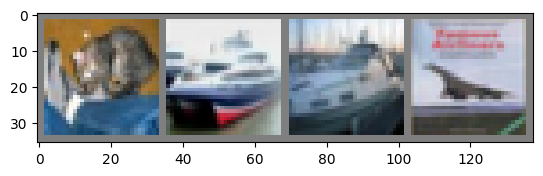

GroundTruth: cat ship ship plane
Predicted: cat ship ship plane


In [7]:
# 5. Visualize Predictions
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:', ' '.join(classes[labels[j]] for j in range(4)))

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join(classes[predicted[j]] for j in range(4)))

### 5. Visualize Predictions: Step-by-Step Explanation

#### **Image Visualization Helper Function (`imshow`)**

```python
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
```

- This function is used to display an image, especially after it has been normalized. Since the images were normalized to have pixel values in the range `[-1, 1]`, we unnormalize them back to `[0, 1]` using `img = img / 2 + 0.5`.
  - The normalization formula used earlier for the images was `(0.5, 0.5, 0.5)` for the mean and `(0.5, 0.5, 0.5)` for the standard deviation, which means pixel values are scaled to a range of `[-1, 1]`.
  - To unnormalize, we reverse this by dividing the pixel values by `2` and adding `0.5`, bringing them back into the `[0, 1]` range.
- **`npimg = img.numpy()`** converts the image tensor to a NumPy array so that it can be processed by `matplotlib` for display.
- **`np.transpose(npimg, (1, 2, 0))`** rearranges the image dimensions from `(C, H, W)` (channels, height, width) to `(H, W, C)` (height, width, channels), which is the format `matplotlib` expects for displaying color images.
- Finally, `plt.imshow(npimg)` displays the image and `plt.show()` renders the plot.

#### **Get Some Test Images**

```python
dataiter = iter(testloader)
images, labels = next(dataiter)
```

- Here, we create an iterator (`dataiter`) from the test dataset loader (`testloader`) and retrieve the next batch of images and labels using `next(dataiter)`. The batch size is defined by the `trainloader` or `testloader`, so this batch contains multiple images and their corresponding labels.
- **`images`** contains a batch of image tensors, and **`labels`** contains their corresponding true labels.

#### **Show the First 4 Images**

```python
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:', ' '.join(classes[labels[j]] for j in range(4)))
```

- **`images[:4]`**: We are selecting the first 4 images from the batch (this is just for display purposes).
- **`torchvision.utils.make_grid()`**: This function arranges a list of images into a grid for better visualization. Here, it is used to combine the first 4 images into a single grid.
- **`imshow()`**: The `imshow` function is then called to display the grid of images.
- **Ground Truth Labels**: The true labels for the first 4 images are printed. This is done by converting the label indices to their corresponding class names using the `classes` list. The `join()` function is used to format the output as a string.


#### **Make Predictions with the Model**

```python
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
```

- **Transfer to Device**: The images and labels are transferred to the same device (GPU or CPU) as the model using `images.to(device)` and `labels.to(device)`. This ensures that the computations happen on the same device.
- **Model Predictions**: The model is then used to make predictions on the input images (`outputs = model(images)`). The `outputs` are the raw class scores (logits) for each image.
- **`torch.max(outputs, 1)`**: We use the `torch.max()` function to find the index of the class with the highest score for each image. This gives the predicted class for each image.


#### **Display Predicted Labels**

```python
print('Predicted:', ' '.join(classes[predicted[j]] for j in range(4)))
```

- We print the predicted class names for the first 4 images. The predicted class indices are converted to class names using the `classes` list, similar to how we displayed the ground truth labels earlier.

### Exercise: Full Code Overview

Below is the complete code for defining, training, evaluating, and visualizing the CNN model. Take a moment to **look through the entire code** and **run it**. As you go through it, try to recall what each part of the code does. If you don’t remember or need a refresher, feel free to revisit the explanations provided earlier.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [9]:
# 1. Load and Transform Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Files already downloaded and verified


In [10]:
# 2. Define CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
# 3. Train the CNN
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")

print("Training Finished!")

Epoch 1, Loss: 1.4432
Epoch 2, Loss: 1.0896
Epoch 3, Loss: 0.9421
Epoch 4, Loss: 0.8340
Epoch 5, Loss: 0.7520
Epoch 6, Loss: 0.6772
Epoch 7, Loss: 0.6122
Epoch 8, Loss: 0.5537
Epoch 9, Loss: 0.5002
Epoch 10, Loss: 0.4486
Training Finished!


In [12]:
# 4. Evaluate Model
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 72.94%


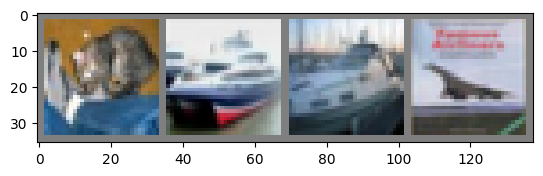

GroundTruth: cat ship ship plane
Predicted: cat ship ship plane


In [13]:
# 5. Visualize Predictions
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:', ' '.join(classes[labels[j]] for j in range(4)))

# Predict
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join(classes[predicted[j]] for j in range(4)))